## Bayesian Blocks

### Paul Anzel, DATEDATEDATE

If we're trying to histogram our data, we'd like some idea of how many bins we should use. Too few and you miss features, too many and statistical variation will take over. You could just try several and see what looks good, but this is effort intensive and not a particularly coherent (or algorithmizable) way to deal with things.

There are a few standard techniques:
- If you know something about how you're collecting the data (e.g. it's from a detector with finite precision) this could give you some useable bin sizes.
- A bunch of standard approaches, like:
 - __Sturges' Rule__: Number of bins $k = \lceil 1 + \log_2 n \rceil$
 - __Scott's Rule__: For sample standard deviation $s$, use bin width $w = 3.49 s n^{-1/3}$
 - __Freedman-Diaconis__: For interquartile range $IQR$, $w = 2 IQR n^{-1/3}$

However, these tend to oversmooth data, and your binning could probably be finer.

In [1]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import numpy.random as rd
from scipy import stats
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

In [2]:
rd.seed(267)
N = 1000
# A very complicated and disperse dataset
cauchy1 = stats.cauchy(-5, 1.8)
frac_C1 = 0.1
cauchy2 = stats.cauchy(-4, 0.8)
frac_C2 = 0.4
cauchy3 = stats.cauchy(-1, 0.3)
frac_C3 = 0.1
cauchy4 = stats.cauchy(2, 0.8)
frac_C4 = 0.2
cauchy5 = stats.cauchy(4, 1.5)
frac_C5 = 0.2
X_vals = np.concatenate([cauchy1.rvs(np.around(frac_C1*N)),
                         cauchy2.rvs(np.around(frac_C2*N)),
                         cauchy3.rvs(np.around(frac_C3*N)),
                         cauchy4.rvs(np.around(frac_C4*N)),
                         cauchy5.rvs(np.around(frac_C5*N))])
# Cauchy distributions very far out, so truncate 
X_vals = X_vals[(X_vals > -15) & (X_vals < 15)]

X_sample = np.linspace(-15, 15, 300)
sample_dist = (frac_C1*cauchy1.pdf(X_sample) +
               frac_C2*cauchy2.pdf(X_sample) +
               frac_C3*cauchy3.pdf(X_sample) +
               frac_C4*cauchy4.pdf(X_sample) +
               frac_C5*cauchy5.pdf(X_sample))

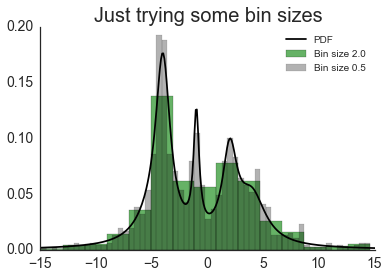

In [3]:
plt.hist(X_vals, bins=15, normed=True, color='g', alpha=0.6, label='Bin size 2.0')
plt.hist(X_vals, bins=60, normed=True, color='k', alpha=0.3, label='Bin size 0.5')
plt.plot(X_sample, sample_dist, color='k', label='PDF')
plt.legend()
plt.title('Just trying some bin sizes', fontsize=20)
plt.tick_params(labelsize=14)
sns.despine()

In [4]:
sturges_bins = np.ceil(1 + np.log2(N))
print("Number of bins for Sturges' Rule: %d" % sturges_bins)

scotts_bins = np.ceil(float(30)/(3.49*X_vals.std()*N**(float(-1)/3)))
print("Number of bins for Scott's Rule: %d" % scotts_bins)

Number of bins for Sturges' Rule: 11
Number of bins for Scott's Rule: 20


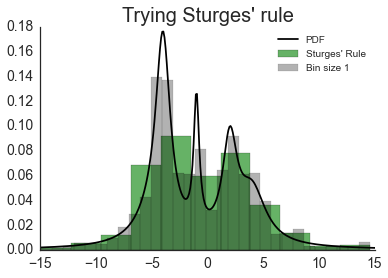

In [5]:
use_sturges = True

if use_sturges:
    plt.hist(X_vals, bins=sturges_bins, normed=True, color='g', alpha=0.6, label="Sturges' Rule")
    plt.title("Trying Sturges' rule", fontsize=20)
else:
    plt.hist(X_vals, bins=scotts_bins, normed=True, color='g', alpha=0.6, label="Scott's Rule")   
    plt.title("Trying Scott's rule", fontsize=20)
plt.hist(X_vals, bins=30, normed=True, color='k', alpha=0.3, label='Bin size 1')
plt.plot(X_sample, sample_dist, color='k', label='PDF')
plt.legend() 
plt.tick_params(labelsize=14)
sns.despine()

### Knuth's Rule
#### (Kevin Knuth, not Donald Knuth)

A problem with the above rules is they generally assume some basic form of what your data is supposed to look like (generally, we think it'll be approximately normal). Since our PDF above is definitely non-normal, we run into problems.

The derivation of Knuth's rule is gone through in the reference for it below, but here's a quick overview.

We want to use Bayesian analysis to figure out an ideal number of bins to use. We start with a prior assumption that the number of blocks is uniformly distributed between 0 and $C$, the maximum number of blocks we want to consider.

$$p(M|I) = C^{-1} \: if \: 1 \leq M \leq C \: else \: 0$$

We have $M$ bins that we need to stick these points in, so take a Jeffrey's prior (a common way of dealing with some information) of the multinomial for bin parameters $\pi_1, \pi_2, ..., \pi_{M_1}$, where $\pi_i$ is the normed volume of each histogram box ($\sum_{i=1}^{M} \pi_i = 1)$.

$$p(\underline \pi | M, I) = \frac{\Gamma(M/2)}{\Gamma(1/2)^M} \left[ \pi_1 \pi_2 \dots \pi_{M-1} \left( 1 - \sum_{i=0}^{M-1} \pi_i \right) \right]^{-1/2}$$

Last, we have the joint likelihood. If you have $M$ bins with various volumes $\pi_i$, the probability of of getting a point in bin $k$ is with quantities of points $n_k$ in each, then you should expect a probability of getting in

$$p = \frac{M}{V}\pi_k$$

Multiply for all the points gives

$$p(\underline d | \underline \pi, M, I) = \left( \frac{M}{V} \right)^N \pi_1^{n_1} \pi_2^{n_2} \dots \pi_{M-1}^{n_{M-1}} \pi_M^{n_M}$$

### Posterior Probability

From Bayes' Theorem the posterior probability for the histogram is the product of the priors and the likelihood.

$$p(\underline \pi, M | \underline d, I) \propto p(\underline \pi | M, I) p(M|I) p(\underline d | \underline \pi, M, I)$$

Sticking everything from above in gives

$$ p(\underline \pi, M | \underline d, I) \propto \frac{\Gamma(M/2)}{\Gamma(1/2)^M}\left( \frac{M}{V} \right)^N \pi_1^{n_1-\frac{1}{2}} \pi_2^{n_2-\frac{1}{2}} \dots \pi_{M-1}^{n_{M-1}-\frac{1}{2}} \left( 1 - \sum_{i=0}^{M-1} \pi_i \right)^{n_M-\frac{1}{2}}$$

For $1 \leq M \leq C$.

Next, integrate over all possible values of $\pi_1, \pi_2, \dots, \pi_{M-1}$. Two pages of solving integrals gives marginal posterior probability:

$$ p(M|\underline d, I) \propto \left( \frac{M}{V}\right)^N \frac{\Gamma \left(\frac{M}{2} \right)}{\Gamma \left( \frac{1}{2} \right)^M} \frac{\prod_{k=1}^M \Gamma \left( n_k + \frac{1}{2}\right)}{\Gamma \left( N + \frac{M}{2}\right)}$$

So now we just have to maximize this. It's easier when you take a logarithm, so maximize:

$$ \log p(M|\underline d, I) = N \log M + \log \Gamma \left( \frac{M}{2} \right) - M \log \Gamma \left( \frac{1}{2} \right) - \log \Gamma \left( N + \frac{M}{2} \right) + \sum_{k=1}^{M} \log \Gamma \left( n_k + \frac{1}{2} \right) + K$$

Where $K$ is just a constant. Just compute this for every value of $M$ from 1 to $C$ and pick the value that gives you the highest value.

To compute $\log \Gamma$, you can use ``scipy.special.gammaln()`` in Python, ``gammaln()`` in MATLAB or ``lgamma()`` in R, which should be the most accurate. Alternately:

$$ \log \Gamma (m) = \sum_{k=1}^{m-1} \log k $$
$$ \log \Gamma \left(m + \frac{1}{2} \right) = \frac{1}{2}\log \pi - n \log 2 + \sum_{k=1}^{m} \log(2k-1)$$

In [6]:
from scipy.special import gammaln

def KN_loglikelihood(data, M):
    '''Knuth's Rule implementation for histograms, single M.
Usage:
    LL = KN_loglikelihood(data, M)
Where:
    data is a (N,) vector of data points
    M is maximum number of points to consider.
'''
    N = len(data)
    n, _ = np.histogram(data,bins=M)
    part1 = N*np.log(M) + gammaln(0.5*M) - gammaln(N+0.5*M)
    part2 = - M*gammaln(0.5) + np.sum(gammaln(n+0.5))
    LL = part1 + part2
    return LL


def optBINS(data, maxM):
    '''Knuth's Rule implementation for  histograms.
Usage:
    optM = optBINS(data, maxM)
Where:
    data is a (N,) vector of data points
    maxM is maximum number of points to consider.

Ref: K.H. Knuth. 2012. Optimal data-based binning for histograms
and histogram-based probability density models, Entropy.
'''
    #     if size(data)>2 | size(data,1)>1
    #     error(’data dimensions must be (1,N)’);
    #     end
    # Simply loop through the different numbers of bins
    # and compute the posterior probability for each.
    logp = np.zeros(maxM,)
    for M in np.arange(maxM):
        logp[M] = KN_loglikelihood(data, M+1)
    optM = np.argmax(logp) + 1
    return optM

In [7]:
start_time = time.clock()
optval_Knuth = optBINS(X_vals, 100)
end_time = time.clock()
print("Knuth's rule optimal number of bins: %d" % optval_Knuth)
print("Time to calculate: %.5f sec" % (end_time - start_time))

Knuth's rule optimal number of bins: 26
Time to calculate: 0.01129 sec


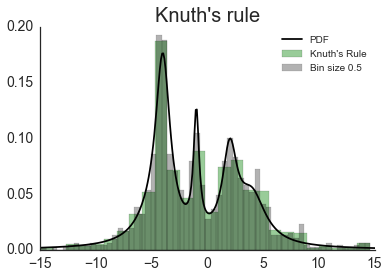

In [8]:
plt.hist(X_vals, bins=optval_Knuth, normed=True, color='g', alpha=0.4, label="Knuth's Rule")   
plt.title("Knuth's rule", fontsize=20)
plt.hist(X_vals, bins=60, normed=True, color='k', alpha=0.3, label='Bin size 0.5')
plt.plot(X_sample, sample_dist, color='k', label='PDF')
plt.legend()
plt.tick_params(labelsize=14)
sns.despine()

Additional numerical wrangling tells us that the expected bin height for bin $k$ is

$$ \langle h_k \rangle = \left( \frac{M}{V} \right) \left( \frac{n_k + \frac{1}{2}}{N + \frac{M}{2}} \right) $$

(Note this doesn't go to zero for zero data in the bin).

And the variance of the bin height for bin $k$ is

$$ \sigma_k = \left( \frac{M}{V}\right)^2 \frac{(n_k + \frac{1}{2})(N - n_k + \frac{M-1}{2})}{(N + \frac{M}{2} + 1)(N + \frac{M}{2})^2}$$

In [9]:
V_KR = max(X_vals) - min(X_vals)
N_KR = len(X_vals)
M_KR = optval_Knuth
n_KR, binEdges_KR = np.histogram(X_vals, bins=M_KR)
binCenters_KR = 0.5*(binEdges_KR[1:]+binEdges_KR[:-1])


exp_hist_height = (M_KR/V_KR)*(n_KR + 0.5)/(N_KR + 0.5*M_KR)
var_hist_height = ((M_KR/V_KR)**2)*(n_KR + 0.5)*(N_KR - n_KR + 0.5*(M_KR-1))/((N_KR + 0.5*M_KR + 1)*(N_KR + 0.5*M_KR)**2)
std_hist_height = np.sqrt(var_hist_height)

/Users/anzelp/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


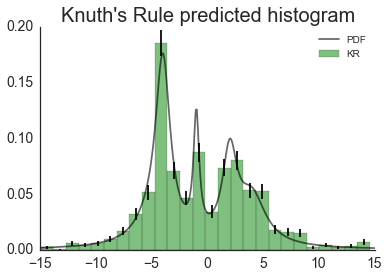

In [10]:
plt.bar(binEdges_KR[:-1], exp_hist_height, width=(V_KR/M_KR), color='g', alpha=0.5, yerr=std_hist_height, ecolor='k', label='KR')
plt.plot(X_sample, sample_dist, color='k', alpha=0.6, label='PDF')
plt.ylim([0, .2])
plt.title("Knuth's Rule predicted histogram", fontsize=20)
plt.legend()
plt.tick_params(labelsize=14)
sns.despine()

Here's our log-likelihood function for our data:

In [11]:
M_range = np.arange(1, 200)
LL_KR = np.empty(M_range.size)

for ind in range(len(LL_KR)):
    M = M_range[ind]
    LL_KR[ind] = KN_loglikelihood(X_vals, M)

M_ind = np.argwhere(M_range == optval_Knuth)
LL_at_max = LL_KR[M_ind]

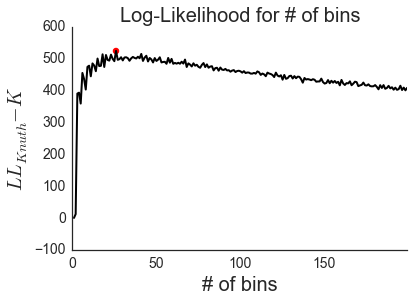

In [19]:
plt.plot(M_range, LL_KR, color='k', linewidth=2)
plt.scatter(optval_Knuth, LL_at_max, color='r', marker='o', linewidth=2)
plt.title("Log-Likelihood for # of bins", fontsize=20)
plt.xlim([0, M_range.max()])
plt.xlabel('# of bins', fontsize=20)
plt.ylabel(r'$LL_{Knuth} - K$', fontsize=20)
plt.tick_params(labelsize=14)
sns.despine()

One thing you need to be conscious about is digitization/rounding error. The data above has extremely high precision, but if we rounded the data to the nearest integer, weird things happen.

In [13]:
X_vals_rd = np.around(X_vals, decimals=0)
optval_Knuth_rd = optBINS(X_vals_rd, 300)
print('Optimal number of bins for digitized data is %d :(' % optval_Knuth_rd)

Optimal number of bins for digitized data is 300 :(


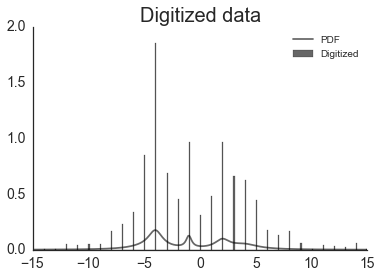

In [14]:
plt.hist(X_vals_rd, bins=optval_Knuth_rd, normed=True, color='k', alpha=0.6, label="Digitized")
plt.plot(X_sample, sample_dist, color='k', alpha=0.6, label='PDF')
plt.title("Digitized data", fontsize=20)
plt.legend()
plt.tick_params(labelsize=14)
sns.despine()

To fight this, you need to add a randomized element to your digitized data ($\approx$ the digitization width) to smooth this out.

In [15]:
rd.seed(425)
X_vals2 = X_vals_rd + (rd.rand(X_vals.size) -0.5)
optval_Knuth_sm = optBINS(X_vals2, 300)
print('Optimal number of bins for smoothed digitized data is %d' % optval_Knuth_sm)

Optimal number of bins for smoothed digitized data is 29


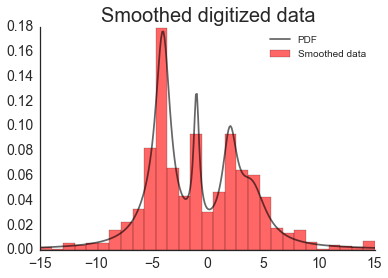

In [16]:
plt.hist(X_vals_rd, bins=optval_Knuth_sm, normed=True, color='r', alpha=0.6, label="Smoothed data")
plt.plot(X_sample, sample_dist, color='k', alpha=0.6, label='PDF')
plt.title("Smoothed digitized data", fontsize=20)
plt.legend()
plt.tick_params(labelsize=14)
sns.despine()

One common example is when you're working with time-series data, where your time values will be binned. The canonical [Old Faithful eruption data](http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat) only gives times up to the nearest minute, and so the Knuth's Rule may try to prioritize the fact that the minutes are discrete. Adding the randomized $\pm 30$ seconds should mitigate this.

### Bayesian Blocks [Scargle, 2012]

Knuth's rule let us figure out an ideal number of equal-bin widths, but what about for unequal-sized blocks? And can we do something about the digitization error? Bayesian Blocks solves this problem.

This technique is especially useful for time-series data, as you're basically trying to ask "when am I really seeing an important change in the number of incoming events?" and so having variable bin lengths/positions is a real asset. One could even consider this to be isotonic-regression-like, through without the enforcement that the final fit be monotonic.

For the number of blocks to use, a Bayesian prior that is geometric is used

$$P(M) \propto \gamma^{M}$$

for $0 \leq M \leq M_{max}$, $0 < \gamma < 1$. This is basically saying that we assume that the number of blocks should be reasonably small. This gives an expected number of blocks

$$\langle M \rangle = \frac{M_{max} \gamma^{M_{max}+1} + 1}{\gamma^{M_{max}+1} - 1} + \frac{1}{1 - \gamma}$$

and the log-likelihood ends up giving a "$-\log \gamma$" later. $\gamma$ ends up being *kind* of like a smoothing parameter.

The block edges, or *change points*

In [ ]:
def bayesian_blocks(t):
    """Bayesian Blocks Implementation

    By Jake Vanderplas.  License: BSD
    Based on algorithm outlined in http://adsabs.harvard.edu/abs/2012arXiv1207.5578S

    Parameters
    ----------
    t : ndarray, length N
        data to be histogrammed

    Returns
    -------
    bins : ndarray
        array containing the (N+1) bin edges

    Notes
    -----
    This is an incomplete implementation: it may fail for some
    datasets.  Alternate fitness functions and prior forms can
    be found in the paper listed above.
    """
    # copy and sort the array
    t = np.sort(t)
    N = t.size

    # create length-(N + 1) array of cell edges
    edges = np.concatenate([t[:1],
                            0.5 * (t[1:] + t[:-1]),
                            t[-1:]])
    block_length = t[-1] - edges

    # arrays needed for the iteration
    nn_vec = np.ones(N)
    best = np.zeros(N, dtype=float)
    last = np.zeros(N, dtype=int)

    #-----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    #-----------------------------------------------------------------
    for K in range(N):
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        width = block_length[:K + 1] - block_length[K + 1]
        count_vec = np.cumsum(nn_vec[:K + 1][::-1])[::-1]

        # evaluate fitness function for these possibilities
        fit_vec = count_vec * (np.log(count_vec) - np.log(width))
        fit_vec -= 4  # 4 comes from the prior on the number of changepoints
        fit_vec[1:] += best[:K]

        # find the max of the fitness: this is the K^th changepoint
        i_max = np.argmax(fit_vec)
        last[K] = i_max
        best[K] = fit_vec[i_max]

    #-----------------------------------------------------------------
    # Recover changepoints by iteratively peeling off the last block
    #-----------------------------------------------------------------
    change_points =  np.zeros(N, dtype=int)
    i_cp = N
    ind = N
    while True:
        i_cp -= 1
        change_points[i_cp] = ind
        if ind == 0:
            break
        ind = last[ind - 1]
    change_points = change_points[i_cp:]

    return edges[change_points]

https://newton.cx/~peter/2013/05/bayesian-blocks-analysis-in-python/

### Implementation in AstroPy

http://docs.astropy.org/en/latest/visualization/histogram.html

Happily, these routines have already been implemented for us in the AstroPy module (which is a default installation in conda). 

In [17]:
# from astropy.stats import knuth_bin_width, bayesian_blocks
import astropy.stats as aps

/Users/anzelp/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


References:
- Knuth's Rule: [Optimal Data-Based Binning for Histograms](http://arxiv.org/pdf/physics/0605197v2.pdf)
- Bayesian Blocks: [Studies in Astronomial Time Series Analysis. VI. Bayesian Block Representations](http://arxiv.org/pdf/1207.5578.pdf)
- http://arxiv.org/pdf/math/0309285.pdf